In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import itertools
import warnings

warnings.filterwarnings("ignore") 

In [2]:
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/poiupoiu/how-to-use-sarimax
#https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

## Reading and preprocessing the data


### NASA GISTEMP Global Means

In [2]:
glb = read_csv('weather_data/GLB.Ts.csv', skiprows=1)
glb.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.76,-0.35,-0.42,-0.60,-0.30,-0.42,-0.41,0.13,-0.44,-0.60,-0.45,-0.47,-0.43,***,***,-0.44,-0.24,-0.50
1,1881,-0.74,-0.56,-0.31,-0.21,0.02,-1.05,-0.47,-0.19,-0.29,-0.42,-0.50,-0.09,-0.40,-.43,-.59,-0.16,-0.57,-0.40
2,1882,0.18,-0.05,-0.03,-0.54,-0.33,-0.97,-0.66,-0.06,-0.02,-0.25,-0.34,-0.62,-0.31,-.26,.01,-0.30,-0.56,-0.20
3,1883,-0.62,-0.89,-0.40,-0.26,-0.30,0.50,0.04,-0.10,-0.40,-0.51,-0.63,-0.33,-0.32,-.35,-.71,-0.32,0.15,-0.51
4,1884,-0.56,-0.30,-0.36,-0.90,-1.16,-0.79,-0.81,0.19,-0.33,-0.73,-0.78,-0.97,-0.63,-.57,-.40,-0.81,-0.47,-0.61


In [3]:
#https://data.giss.nasa.gov/gistemp/
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb_formatted = preprocess_temp_anomaly(glb)
glb_formatted.head()

,anomaly
DateTime,
1880-01-01,-0.76
1880-02-01,-0.35
1880-03-01,-0.42
1880-04-01,-0.60
1880-05-01,-0.30


### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [4]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

maunaloa = read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

maunaloa['DateTime']  = pd.to_datetime(maunaloa.Year.map(str) + '-' + maunaloa.Month.map(str))
maunaloa = maunaloa.set_index(['DateTime'])

maunaloa.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-02-01,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


In [5]:
maunaloaFilled = maunaloa[['CO2filled', 'seasonalCO2filled']].copy()
maunaloaFilled.replace(to_replace=[-99.99], value=np.nan, inplace=True)

### The Oceanic Niño Index (ONI) 

In [6]:
#https://data.humdata.org/dataset/monthly-oceanic-nino-index-oni
#https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt

In [7]:
enso = read_csv('weather_data/ONIindex.csv',delim_whitespace=True)

In [8]:
enso['DateTime'] = pd.to_datetime(enso.YR.map(str) + '-' + enso.MON.map(str))
enso = enso.set_index(['DateTime']) 

In [9]:
enso.head()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


### Sunspot Number

In [10]:
#http://www.sidc.be/silso/monthlyssnplot
#http://www.sidc.be/silso/newdataset
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)

In [11]:
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))

In [12]:
sunspots = sunspots.set_index(['DateTime'])  

In [13]:
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


### Range there is data of all the variables

In [14]:
#Choosing a range there is data of
anomalyrange = glb_formatted['1960-01-01' : '2018-12-01']
co2range = maunaloaFilled[['CO2filled']]['1960-01-01' : '2018-12-01']  #.CO2filled['1960-01-01' : '2018-12-01']
ensorange = enso[['ANOM']]['1960-01-01' : '2018-12-01']
spotsrange = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

In [15]:
anomalyrange.to_csv('gridsearch_data/anomalyrange.csv')
co2range.to_csv('gridsearch_data/co2range.csv')
ensorange.to_csv('gridsearch_data/ensorange.csv')
spotsrange.to_csv('gridsearch_data/spotsrange.csv')

In [16]:
exogenous = pd.concat([co2range,ensorange,spotsrange], axis=1)

In [17]:
exogenous.tail()

,CO2filled,ANOM,SNvalue
DateTime,,,
2018-08-01,407.10,0.04,8.7
2018-09-01,405.59,0.39,3.3
2018-10-01,405.99,0.86,4.9
2018-11-01,408.12,0.86,5.9
2018-12-01,409.23,0.84,3.1


## Plotting the data

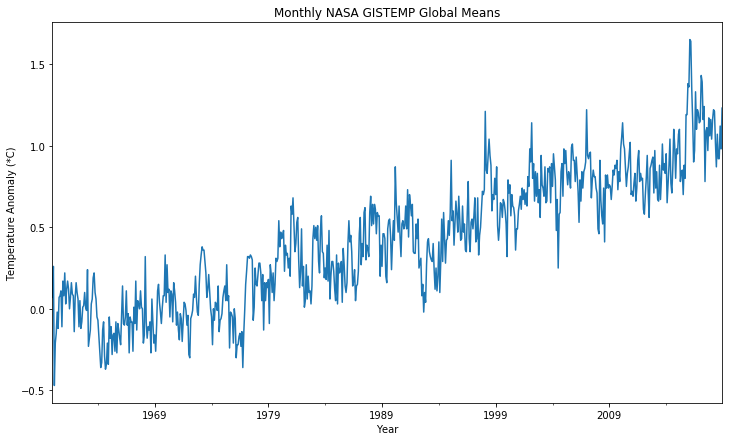

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
anomalyrange.anomaly.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (*C)')
plt.title('Monthly NASA GISTEMP Global Means')
plt.show()


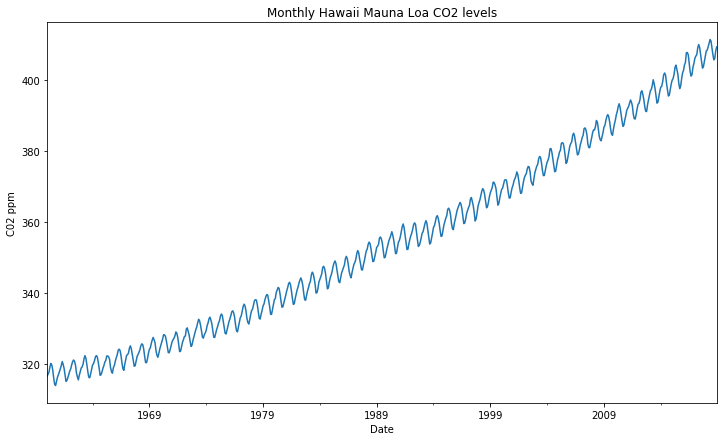

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
co2range.CO2filled.plot(ax=ax)

plt.xlabel('Date')
plt.ylabel('C02 ppm')
plt.title('Monthly Hawaii Mauna Loa CO2 levels')
plt.show()

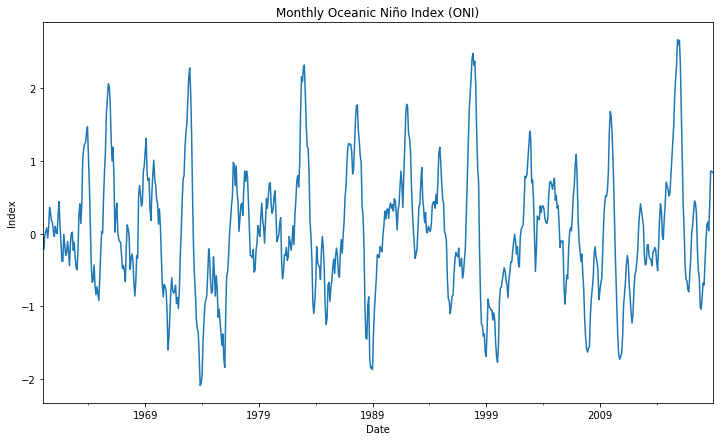

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ensorange.ANOM.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Monthly Oceanic Niño Index (ONI)')
plt.show()

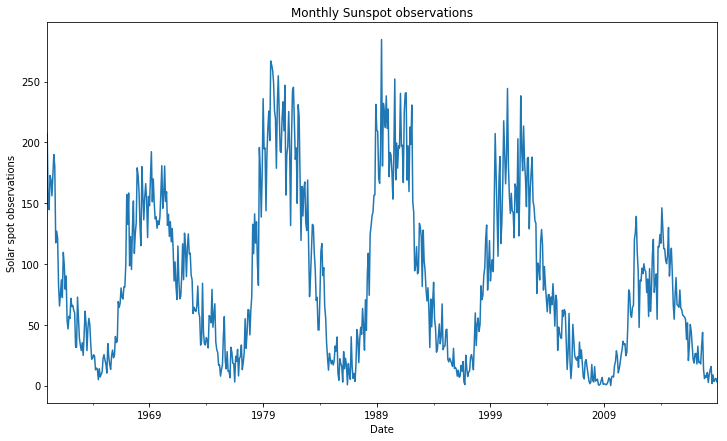

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
spotsrange.SNvalue.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Solar spot observations')
plt.title('Monthly Sunspot observations')
plt.show()

## Seasonal Decompositions

### Temperature anomaly

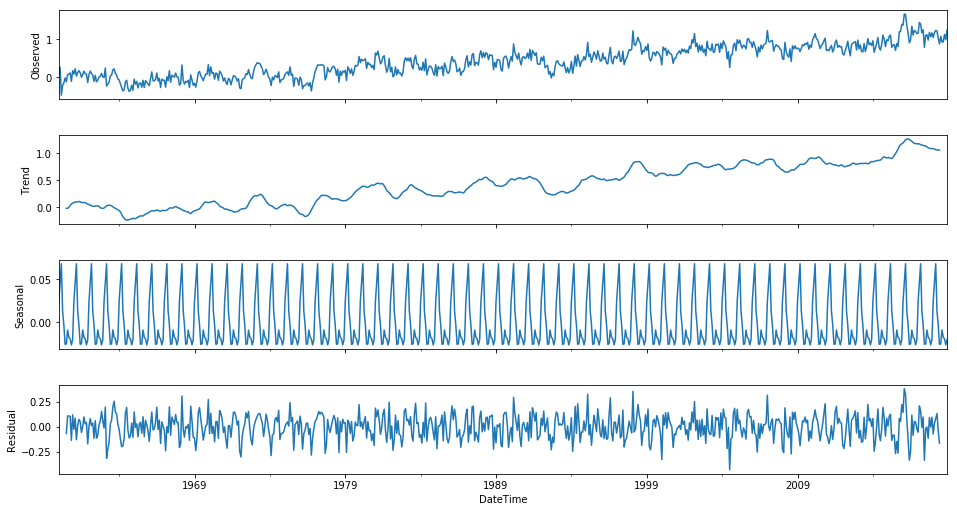

In [22]:
res = sm.tsa.seasonal_decompose(anomalyrange.anomaly,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Hawaii CO2 ppm 

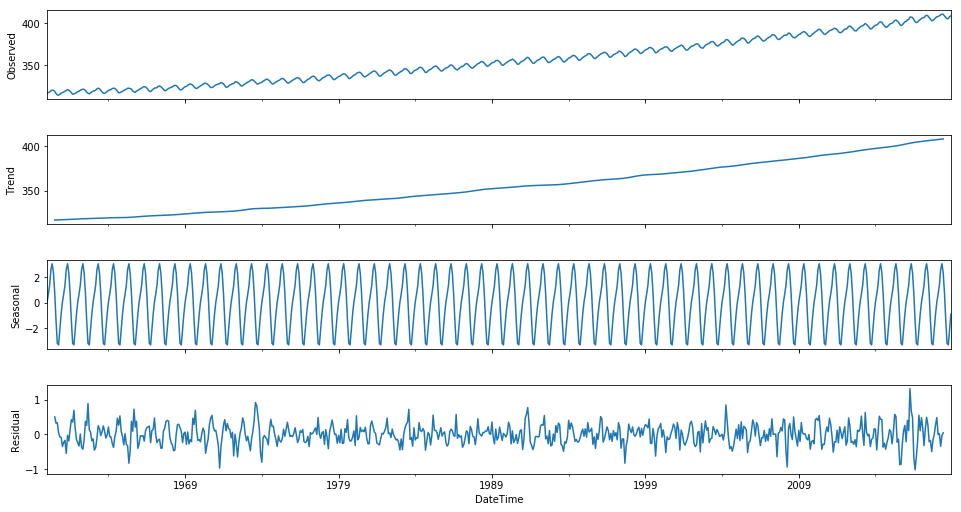

In [23]:
res = sm.tsa.seasonal_decompose(co2range.CO2filled,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### The Oceanic Niño Index (ONI)

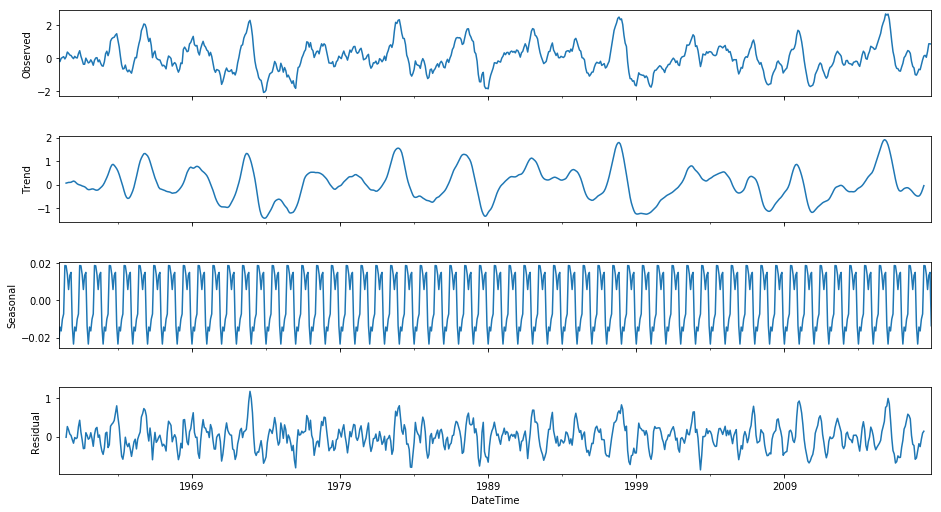

In [24]:
res = sm.tsa.seasonal_decompose(ensorange.ANOM,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Sunspot observations

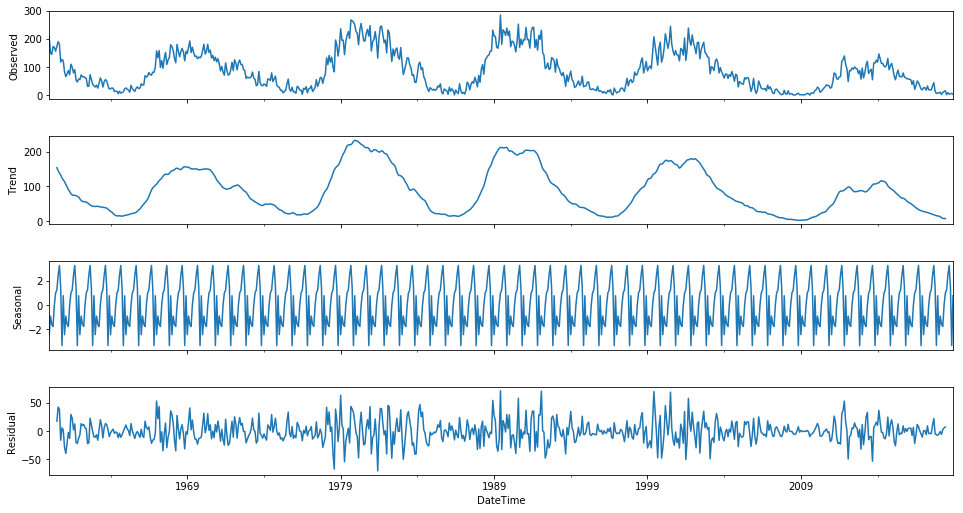

In [25]:
res = sm.tsa.seasonal_decompose(spotsrange.SNvalue,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Model Selection

In [26]:
#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

### Checking Stationarity (Trend)

#### Temperature anomaly

Temperature anomaly lacks identifiable seasonal trend, but has a constant trend

In [27]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# data does not have a unit root and is stationary

p-value:1.6042922157092146e-09


In [28]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.5914744988244862


#### Hawaii CO2 ppm 

CO2 concentration has both a seasonal and a constant trend

In [29]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.9885944880242227


In [30]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:1.0


#### The Oceanic Niño Index (ONI) and Sunspot observations

ONI and Sunspot observations have no trend

In [31]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:4.519555052443993e-08


In [32]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:2.5062854384841634e-09


In [33]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0030167208232305537


In [34]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0007375824522553518


### Correlograms

#### Temperature anomaly

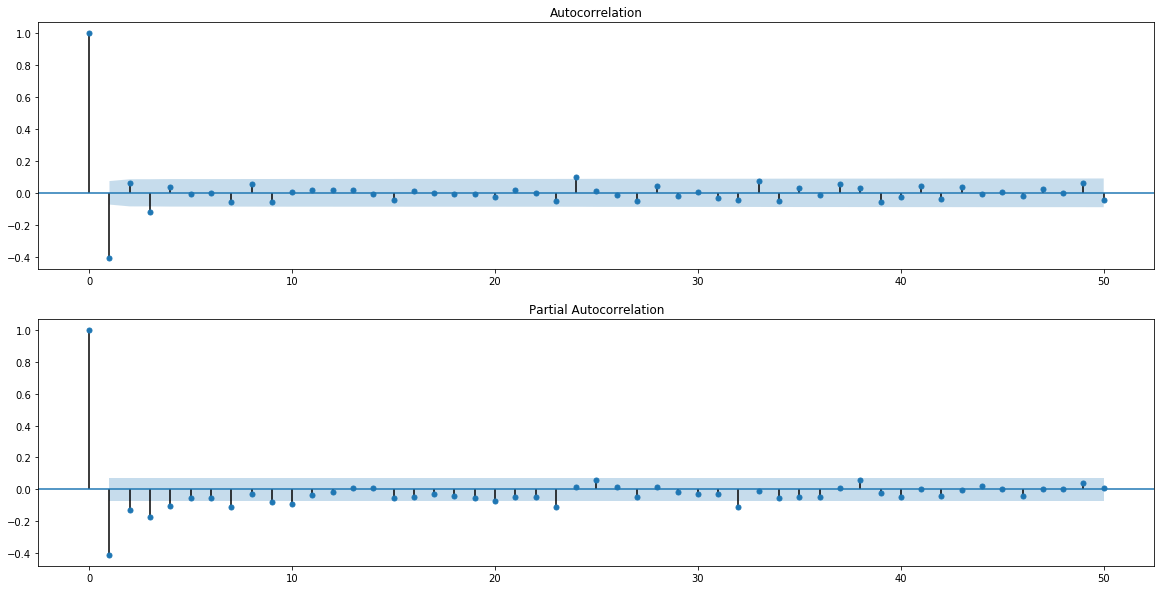

In [36]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### Hawaii CO2 ppm

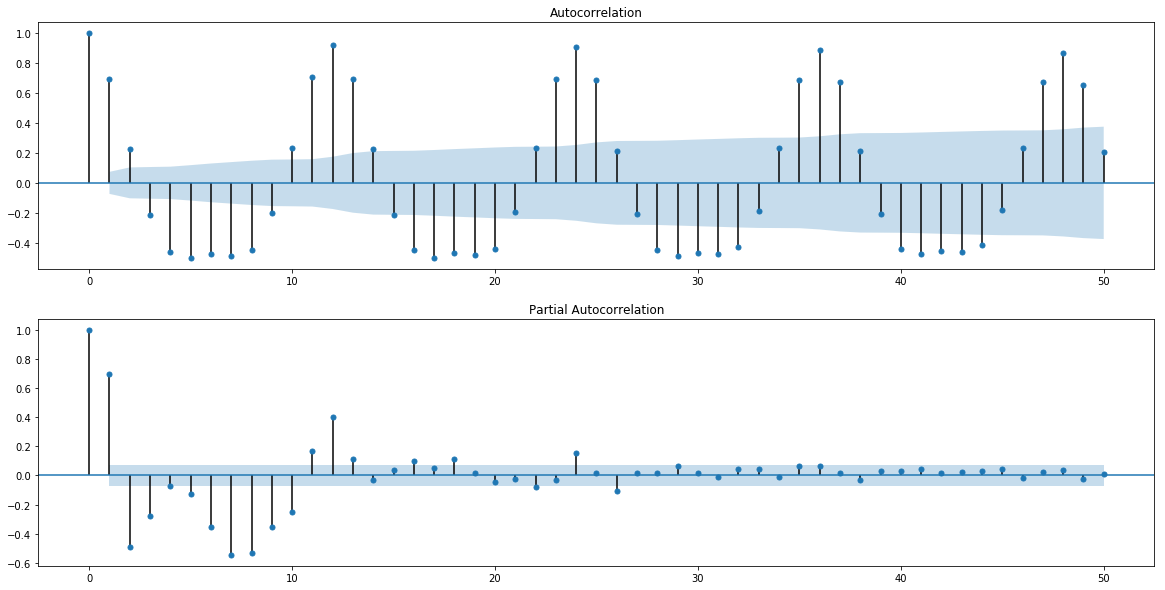

In [37]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### The Oceanic Niño Index (ONI) 

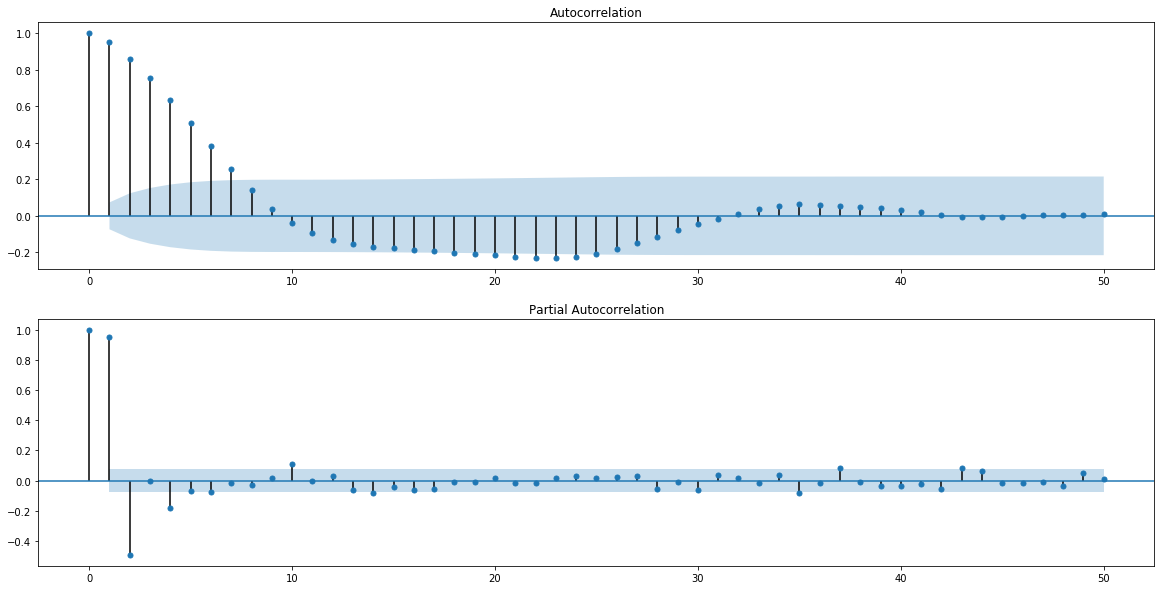

In [38]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ensorange.ANOM, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ensorange.ANOM, lags=50, ax=ax[1])
plt.show()

#### Sunspot observations

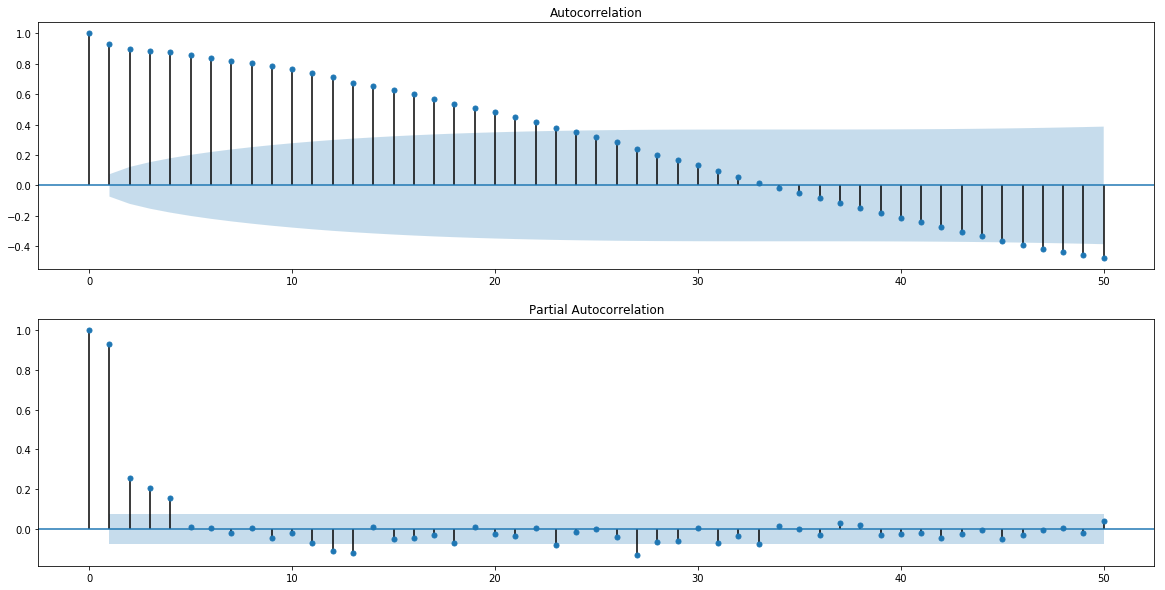

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(spotsrange.SNvalue, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(spotsrange.SNvalue, lags=50, ax=ax[1])
plt.show()

### Train/Test-split

In [19]:
tr_start,tr_end = '1960-01-01','2012-12-01'
te_start,te_end = '2013-01-01','2018-12-01'

train_anomaly, test_anomaly = anomalyrange[tr_start : tr_end], anomalyrange[te_start:te_end]
train_co2, test_co2 = co2range[tr_start : tr_end], co2range[te_start: te_end]
train_enso, test_enso = ensorange[tr_start : tr_end], ensorange[te_start: te_end]
train_spots, test_spots = spotsrange[tr_start : tr_end], spotsrange[te_start: te_end]
train_exogenous, test_exogenous = exogenous[tr_start : tr_end], exogenous[te_start: te_end]


### Gridsearch Hyperparameter selection

Gridsearch parameter selection, does not  support exogenous information. Was used to find parameter fo temperature anomaly and co2. Extremely slow to run so auto.arima (port from R) was used in practice.

SARIMA-gridsearch code from:
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


format gridsearch.py filename.csv. You need to edit the sys.argv[1] parameter in to run these commands


In [ ]:
%run -i gridsearch.py anomalyrange.csv

In [23]:
#Best parameters for anomaly:
#[(2, 1, 2), (0, 0, 0, 0), 'c'] mse: 0.16167729212744297 on test set

In [ ]:
%run -i gridsearch.py co2range.csv

In [ ]:
#Best parameters co2:
#Model[[(0, 1, 0), (0, 1, 2, 12), 'ct']] 0.430
#Model[[(0, 1, 0), (1, 1, 1, 12), 'ct']] 0.440
 #Model[[(0, 1, 0), (1, 0, 2, 12), 'ct']] 0.467

In [ ]:
%run -i gridsearch.py ensorange.csv

In [ ]:
%run -i gridsearch.py spotsrange.csv

## Auto.arima

#### Temperature anomaly

In [24]:
#Lowest aic with no season:
#Fit ARIMA: order=(2, 1, 1); AIC=-690.002, BIC=-667.734, Fit time=0.459 second
#Lowest aic with season 12:
#Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-609.022, BIC=-582.415, Fit time=25.303 seconds

In [20]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-608.660, BIC=-586.487, Fit time=11.407 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-52.071, BIC=-43.202, Fit time=0.140 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-415.457, BIC=-397.719, Fit time=2.493 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-609.128, BIC=-591.389, Fit time=9.112 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-608.560, BIC=-586.387, Fit time=11.918 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-212.633, BIC=-199.330, Fit time=0.451 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-608.246, BIC=-586.073, Fit time=17.510 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-609.022, BIC=-582.415, Fit time=25.303 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-442.094, BIC=-428.791, Fit time=5.077 seconds
Fit ARIMA: order=(0, 1, 2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  636
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 308.564
Date:                            Sun, 17 Feb 2019   AIC                           -609.128
Time:                                    12:41:15   BIC                           -591.389
Sample:                                         0   HQIC                          -602.234
                                            - 636                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.412e-05      0.000      0.092      0.926      -0.000       0.000
ma.L1         -0.5933      0.033    -17.917      0.000      -0.658      -0.528
ma.S.L12      -0.9955      0.162     -6.139      0.000      -1.313      -0.678
sigma2         0.0202      0.003      6.408      0.000       0.014       0.026
===================================================================================
Ljung-Box (Q):                       53.98   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.07   Prob(JB):                         0.34
Heteroskedasticity (H):               1.03   Skew:                             0.12
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
stepwise_fit = pm.auto_arima(train_anomaly, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-666.558, BIC=-648.744, Fit time=0.171 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-504.187, BIC=-495.279, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-625.240, BIC=-611.879, Fit time=0.021 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-662.778, BIC=-649.417, Fit time=0.032 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-690.002, BIC=-667.734, Fit time=0.459 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-634.120, BIC=-616.306, Fit time=0.060 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-688.428, BIC=-661.707, Fit time=0.526 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-687.084, BIC=-655.908, Fit time=0.743 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-688.410, BIC=-661.689, Fit time=0.687 seconds
Total fit time: 2.706 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 350.001
Method:                       css-mle   S.D. of innovations              0.139
Date:                Sun, 17 Feb 2019   AIC                           -690.002
Time:                        12:42:08   BIC                           -667.734
Sample:                             1   HQIC                          -681.356
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   9.49e-05     17.346      0.000       0.001       0.002
ar.L1.D.y      0.4249      0.038     11.074      0.000       0.350       0.500
ar.L2.D.y      0.2634      0.039      6.832      0.000       0.188       0.339
ma.L1.D.y     -1.0000      0.006   -163.985      0.000      -1.012      -0.988
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3023           +0.0000j            1.3023            0.0000
AR.2           -2.9156           +0.0000j            2.9156            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

#### CO2 concentration

In [25]:
#Lowest aic seasonal:
#Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=259.844, BIC=282.017, Fit time=12.238 seconds

In [22]:
stepwise_fit = pm.auto_arima(train_co2, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=259.844, BIC=282.017, Fit time=12.238 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=666.394, BIC=675.264, Fit time=0.308 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=452.528, BIC=470.266, Fit time=2.270 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=262.332, BIC=280.070, Fit time=5.079 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=261.782, BIC=288.389, Fit time=14.361 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=595.137, BIC=612.875, Fit time=0.777 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=261.779, BIC=288.387, Fit time=17.160 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=263.656, BIC=294.698, Fit time=18.954 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=264.847, BIC=291.454, Fit time=13.434 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  636
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -124.922
Date:                            Sun, 17 Feb 2019   AIC                            259.844
Time:                                    12:45:12   BIC                            282.017
Sample:                                         0   HQIC                           268.461
                                            - 636                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.639      0.008       0.000       0.003
ar.L1          0.2379      0.097      2.450      0.014       0.048       0.428
ma.L1         -0.5905      0.083     -7.089      0.000      -0.754      -0.427
ma.S.L12      -0.8844      0.020    -44.202      0.000      -0.924      -0.845
sigma2         0.0849      0.005     17.817      0.000       0.076       0.094
===================================================================================
Ljung-Box (Q):                       42.48   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.36   Prob(JB):                         0.83
Heteroskedasticity (H):               1.27   Skew:                            -0.05
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### The Oceanic Niño Index (ONI)

In [27]:
#Lowest aic no season:
#Fit ARIMA: order=(2, 1, 3); AIC=-40.419, BIC=-9.244, Fit time=0.441 seconds

In [26]:
stepwise_fit = pm.auto_arima(train_enso, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True) 

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-18.625, BIC=-0.811, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 0); AIC=120.728, BIC=129.635, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-14.712, BIC=-1.351, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-16.222, BIC=-2.861, Fit time=0.024 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-19.930, BIC=2.338, Fit time=0.097 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-15.525, BIC=2.290, Fit time=0.038 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-21.142, BIC=5.580, Fit time=0.198 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-39.475, BIC=-3.846, Fit time=0.547 seconds
Fit ARIMA: order=(2, 1, 3); AIC=-40.419, BIC=-9.244, Fit time=0.441 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-21.262, BIC=1.006, Fit time=0.138 seconds
Fit ARIMA: order=(1, 1, 3); AIC=-22.198, BIC=4.524, Fit time=0.221 seconds
Total fit time: 1.818 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  635
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  27.210
Method:                       css-mle   S.D. of innovations              0.232
Date:                Sun, 17 Feb 2019   AIC                            -40.419
Time:                        12:51:14   BIC                             -9.244
Sample:                             1   HQIC                           -28.314
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.016     -0.076      0.940      -0.032       0.030
ar.L1.D.y      1.7603      0.047     37.733      0.000       1.669       1.852
ar.L2.D.y     -0.9153      0.042    -21.799      0.000      -0.998      -0.833
ma.L1.D.y     -1.2934      0.060    -21.381      0.000      -1.412      -1.175
ma.L2.D.y      0.2010      0.067      2.988      0.003       0.069       0.333
ma.L3.D.y      0.3585      0.044      8.199      0.000       0.273       0.444
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9616           -0.4098j            1.0453           -0.0641
AR.2            0.9616           +0.4098j            1.0453            0.0641
MA.1            0.9568           -0.4602j            1.0618           -0.0713
MA.2            0.9568           +0.4602j            1.0618            0.0713
MA.3           -2.4745           -0.0000j            2.4745           -0.5000
-----------------------------------------------------------------------------
"""

#### Sunspot observations

In [ ]:
#Lowest aic no season:
#Fit ARIMA: order=(2, 1, 2); AIC=5811.146, BIC=5837.868, Fit time=0.401 seconds
#Lowest aic 11 year season (follow approximately an 11 year season)
#Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 132); AIC=4934.675, BIC=4951.557, Fit time=408.381 seconds
#Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 132); AIC=4884.352, BIC=4905.455, Fit time=2357.197 seconds

In [30]:
stepwise_fit = pm.auto_arima(train_spots, start_p=1, start_q=1, max_p=3, max_q=3, m=12*11,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  

stepwise_fit.summary()

## ARMA model

gridsearch provides best estimation

In [36]:
sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,1),trend='c',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 349.781
Date:                Sun, 17 Feb 2019   AIC                           -689.563
Time:                        14:42:34   BIC                           -667.311
Sample:                    01-01-1960   HQIC                          -680.921
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005   6.31e-05      8.401      0.000       0.000       0.001
ar.L1          0.4166      0.036     11.658      0.000       0.347       0.487
ar.L2          0.2663      0.036      7.432      0.000       0.196       0.337
ma.L1         -0.9997      0.074    -13.479      0.000      -1.145      -0.854
sigma2         0.0184      0.002     10.874      0.000       0.015       0.022
===================================================================================
Ljung-Box (Q):                       46.77   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.21   Prob(JB):                         0.27
Heteroskedasticity (H):               1.06   Skew:                             0.14
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.048486366451426656


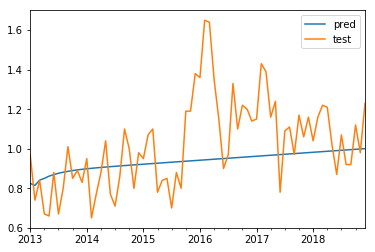

In [37]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

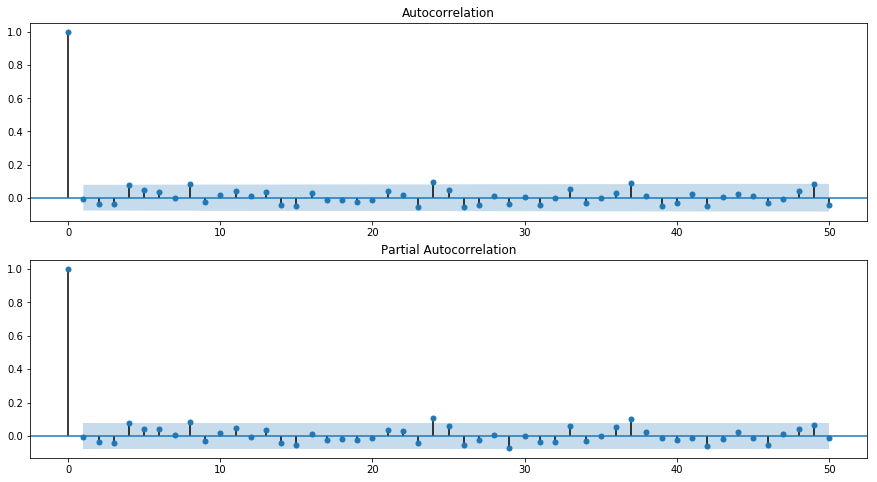

In [38]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

### SARIMAX-model with CO2 as exogenous data

In [21]:
#p = d = q = range(0, 2)
p = range(0,4)
d = range(0,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(0, 0, 0, 0) for x in list(itertools.product(p, d, q))]

In [25]:
warnings.filterwarnings("ignore") 

for param in pdq:

    try:
        mod = sm.tsa.statespace.SARIMAX(train_anomaly,
                                        order=param,
                                        seasonal_order=(0,0,0,0),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False,
                                        exog=train_co2
                                        )

        results = mod.fit()

        print('SARIMAX{} - AIC:{}'.format(param, results.aic))

    except:
        continue

SARIMAX(0, 0, 1) - AIC:5.171266745891941
SARIMAX(0, 0, 2) - AIC:-253.9915676680812
SARIMAX(0, 0, 3) - AIC:-287.78982660219816
SARIMAX(0, 1, 1) - AIC:-682.6628888297496
SARIMAX(0, 1, 2) - AIC:-678.1557308869063
SARIMAX(0, 1, 3) - AIC:-690.8716365425853
SARIMAX(1, 0, 0) - AIC:-541.2039225029928
SARIMAX(1, 0, 1) - AIC:-666.7353157169123
SARIMAX(1, 0, 2) - AIC:-680.2208349877351
SARIMAX(1, 0, 3) - AIC:-692.6404813232758
SARIMAX(1, 1, 0) - AIC:-625.0209217263945
SARIMAX(1, 1, 1) - AIC:-685.9157983315818
SARIMAX(1, 1, 2) - AIC:-676.5497169193254
SARIMAX(1, 1, 3) - AIC:-697.8379684662566
SARIMAX(2, 0, 0) - AIC:-639.1324648412083
SARIMAX(2, 0, 1) - AIC:-668.5969429553427
SARIMAX(2, 0, 2) - AIC:-680.3373996442947
SARIMAX(2, 0, 3) - AIC:-689.2867355100091
SARIMAX(2, 1, 0) - AIC:-652.3613767641355
SARIMAX(2, 1, 1) - AIC:-685.9247325896895
SARIMAX(2, 1, 2) - AIC:-690.5976064583851
SARIMAX(2, 1, 3) - AIC:-702.756020960639
SARIMAX(3, 0, 0) - AIC:-663.8345652557946
SARIMAX(3, 0, 1) - AIC:-675.2913136

In [ ]:
#Best parameters:
#SARIMAX(2, 1, 3) - AIC:-702.75602096063
#SARIMAX(3, 1, 3) - AIC:-702.5325612937312

In [52]:

sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,3),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_co2).fit()
sarimax.summary()
#-683

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 358.495
Date:                Sun, 17 Feb 2019   AIC                           -700.990
Time:                        00:44:36   BIC                           -665.348
Sample:                    01-01-1960   HQIC                          -687.151
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.793      0.073   -2.63e-05       0.001
CO2filled      0.0063      0.004      1.708      0.088      -0.001       0.014
ar.L1          0.0961      0.188      0.512      0.608      -0.271       0.464
ar.L2          0.5822      0.161      3.616      0.000       0.267       0.898
ma.L1         -0.6030      0.200     -3.010      0.003      -0.996      -0.210
ma.L2         -0.5811      0.263     -2.207      0.027      -1.097      -0.065
ma.L3          0.1855      0.093      1.985      0.047       0.002       0.369
sigma2         0.0186      0.001     15.062      0.000       0.016       0.021
===================================================================================
Ljung-Box (Q):                       49.74   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.14   Prob(JB):                         0.48
Heteroskedasticity (H):               1.19   Skew:                             0.09
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.040881898018001635


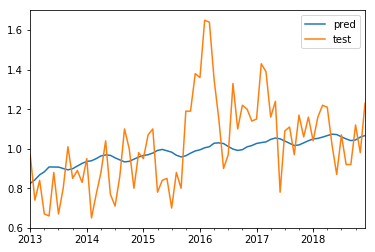

In [53]:
pred = sarimax.predict(tr_end,te_end,exog=test_co2)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

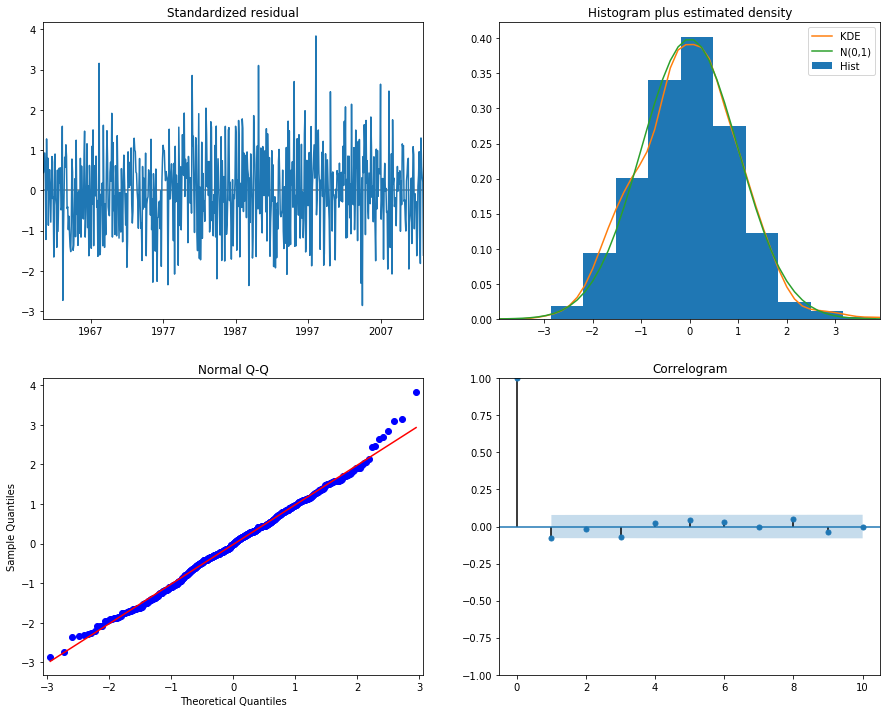

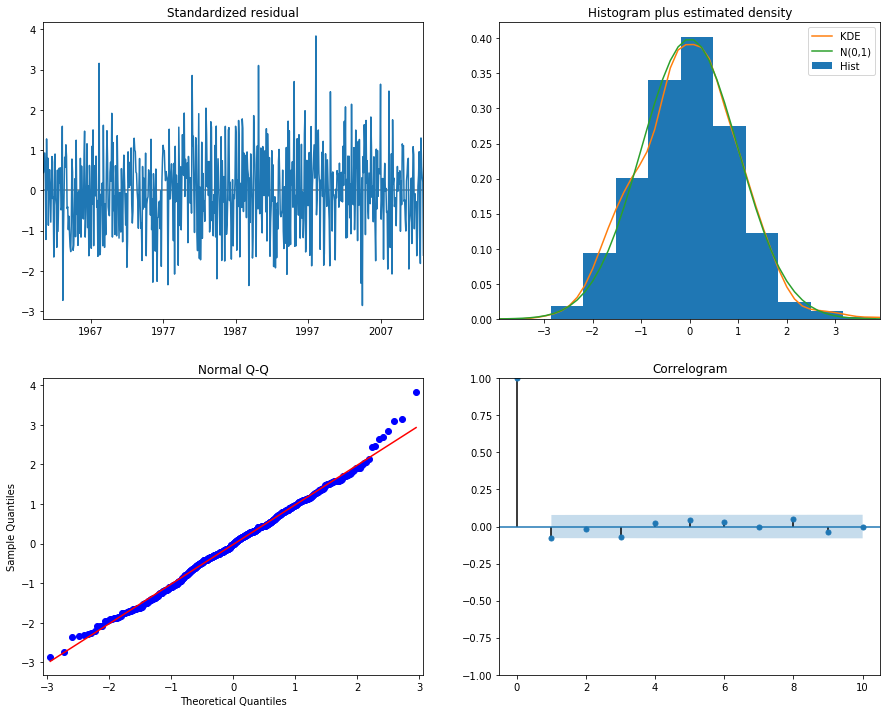

In [28]:
sarimax.plot_diagnostics(figsize=(15, 12))

### SARIMAX-model with all Exogenous data

In [41]:
#p = d = q = range(0, 2)
p = range(0,4)
d = range(0,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(0, 0, 0, 0) for x in list(itertools.product(p, d, q))]

In [43]:
warnings.filterwarnings("ignore") 

for param in pdq:

    try:
        mod = sm.tsa.statespace.SARIMAX(train_anomaly,
                                        order=param,
                                        seasonal_order=(0,0,0,0),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False,
                                        exog=train_exogenous
                                        )

        results = mod.fit()

        print('SARIMAX{} - AIC:{}'.format(param, results.aic))

    except:
        continue

SARIMAX(0, 0, 1) - AIC:22.918068350112804
SARIMAX(0, 0, 2) - AIC:-246.64512971686798
SARIMAX(0, 0, 3) - AIC:-339.3544712282179
SARIMAX(0, 1, 1) - AIC:-681.4464470288331
SARIMAX(0, 1, 2) - AIC:-677.6306170771666
SARIMAX(0, 1, 3) - AIC:-692.3346390196242
SARIMAX(1, 0, 0) - AIC:-538.4434057064863
SARIMAX(1, 0, 1) - AIC:-664.7974915803768
SARIMAX(1, 0, 2) - AIC:-679.0090371870006
SARIMAX(1, 0, 3) - AIC:-693.1682438250897
SARIMAX(1, 1, 0) - AIC:-622.0037554251356
SARIMAX(1, 1, 1) - AIC:-685.2315859480459
SARIMAX(1, 1, 2) - AIC:-674.0231932389912
SARIMAX(1, 1, 3) - AIC:-688.375439212511
SARIMAX(2, 0, 0) - AIC:-635.9907148388348
SARIMAX(2, 0, 1) - AIC:-650.6296794923685
SARIMAX(2, 0, 2) - AIC:-676.3115360741862
SARIMAX(2, 0, 3) - AIC:-687.644440618897
SARIMAX(2, 1, 0) - AIC:-649.5934062084666
SARIMAX(2, 1, 1) - AIC:-676.7365483593665
SARIMAX(2, 1, 2) - AIC:-688.2766397735196
SARIMAX(2, 1, 3) - AIC:-686.5681261898342
SARIMAX(3, 0, 0) - AIC:-660.9072295971753
SARIMAX(3, 0, 1) - AIC:-655.9011048

In [ ]:
#Best parameters:
#SARIMAX(3, 0, 2) - AIC:-689.4473999511904
#SARIMAX(3, 1, 2) - AIC:-690.2586258375666

In [48]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(3,1,2),trend='c',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_exogenous).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 352.411
Date:                Sat, 16 Feb 2019   AIC                           -684.822
Time:                        23:28:25   BIC                           -640.270
Sample:                    01-01-1960   HQIC                          -667.525
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.002      0.431      0.667      -0.003       0.005
CO2filled      0.0058      0.003      1.721      0.085      -0.001       0.012
ANOM           0.0247      0.014      1.711      0.087      -0.004       0.053
SNvalue        0.0002      0.000      0.678      0.497      -0.000       0.001
ar.L1         -0.2064      0.227     -0.911      0.362      -0.650       0.238
ar.L2          0.1771      0.080      2.206      0.027       0.020       0.335
ar.L3         -0.0526      0.062     -0.847      0.397      -0.174       0.069
ma.L1         -0.3477      0.225     -1.546      0.122      -0.788       0.093
ma.L2         -0.3211      0.172     -1.870      0.061      -0.658       0.015
sigma2         0.0192      0.001     18.026      0.000       0.017       0.021
===================================================================================
Ljung-Box (Q):                       53.98   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.07   Prob(JB):                         0.45
Heteroskedasticity (H):               1.14   Skew:                             0.06
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Predictable adding noisy data did not improve the model over co2

SARIMA model MSE:0.0589583047770789


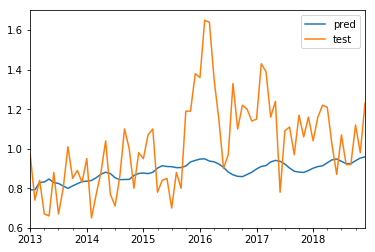

In [49]:
pred = sarimax.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

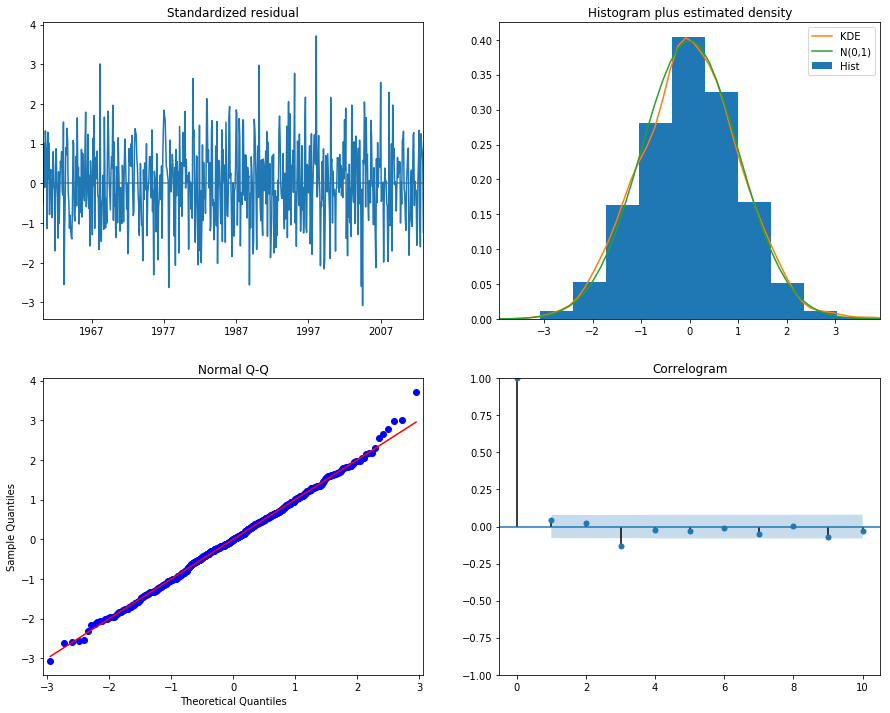

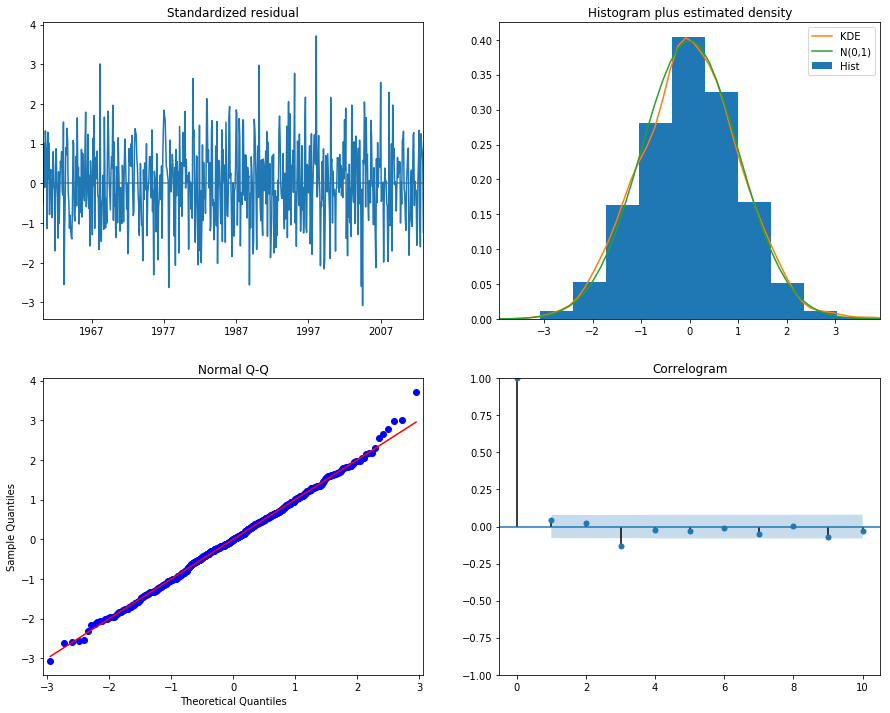

In [191]:
sarimax.plot_diagnostics(figsize=(15, 12))

# Final predictions

### SARIMAX-prediction with CO2

#### Generate future prediction of co2 concentration

In [54]:
sarima = sm.tsa.statespace.SARIMAX(co2range,order=(0,1,0),trend='ct', seasonal_order=(1,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          CO2filled   No. Observations:                  708
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -275.507
Date:                            Sun, 17 Feb 2019   AIC                            561.015
Time:                                    00:45:11   BIC                            583.827
Sample:                                01-01-1960   HQIC                           569.828
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.022      0.174      0.862      -0.039       0.047
drift      -2.628e-06   4.86e-05     -0.054      0.957   -9.79e-05    9.27e-05
ar.S.L12      -0.1629      0.085     -1.907      0.056      -0.330       0.005
ma.S.L12      -0.5465      0.082     -6.663      0.000      -0.707      -0.386
sigma2         0.1861      0.014     13.073      0.000       0.158       0.214
===================================================================================
Ljung-Box (Q):                      144.16   Jarque-Bera (JB):                 4.64
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               1.60   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
prediction   = sarima.get_forecast(steps=373)

In [56]:
prediction.predicted_mean.tail()

2049-09-01    490.631419
2049-10-01    491.086303
2049-11-01    493.023775
2049-12-01    494.360351
2050-01-01    495.652680
Freq: MS, dtype: float64

In [57]:
pred_ci = prediction.conf_int()

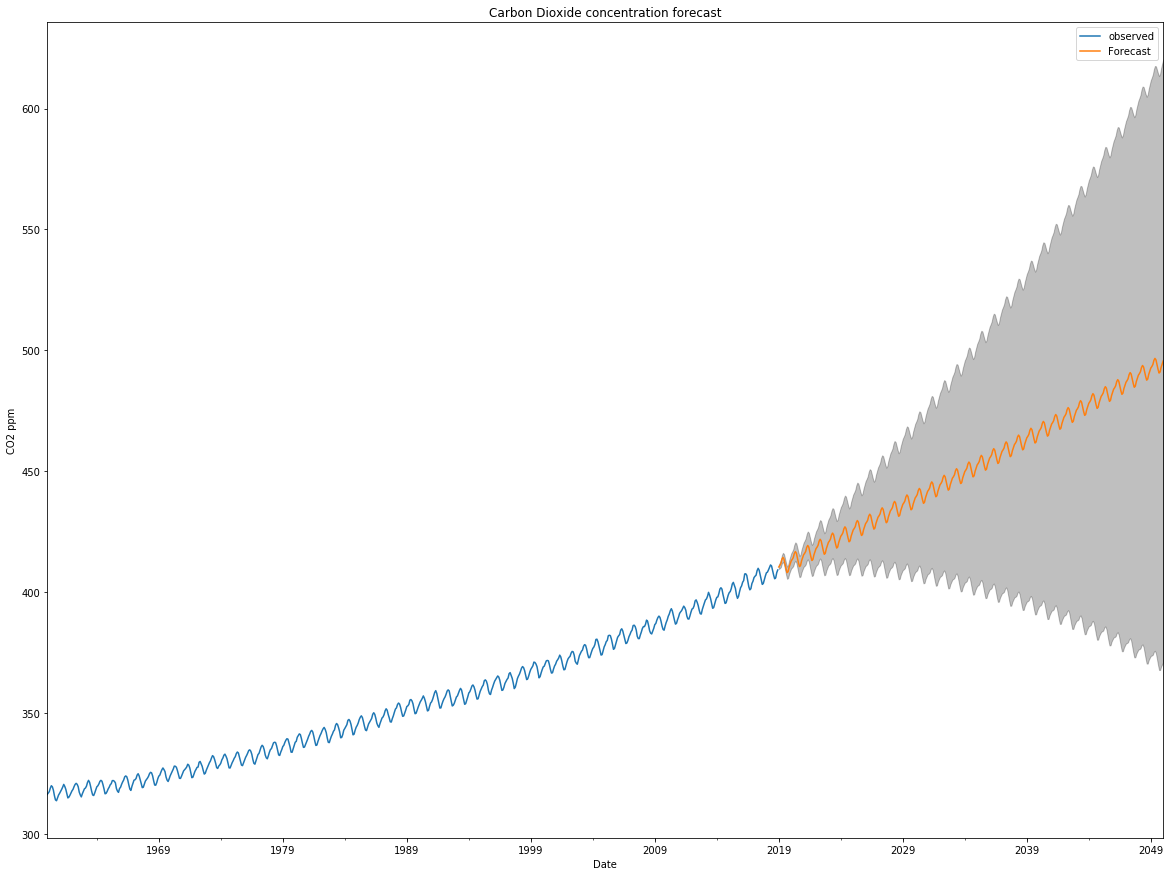

In [58]:
ax = co2range.CO2filled.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Carbon Dioxide concentration forecast')
ax.set_xlabel('Date')
ax.set_ylabel('CO2 ppm')

plt.legend()
plt.show()

#### Prediction with co2 as exogenous variable

In [59]:
mod = sm.tsa.statespace.SARIMAX(anomalyrange.anomaly,order=(2,1,3),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=co2range.values)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 381.577
Date:                Sun, 17 Feb 2019   AIC                           -747.155
Time:                        00:45:25   BIC                           -710.655
Sample:                    01-01-1960   HQIC                          -733.053
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.108      0.035    2.22e-05       0.001
x1             0.0065      0.003      2.229      0.026       0.001       0.012
ar.L1          0.2779      0.216      1.285      0.199      -0.146       0.702
ar.L2          0.3442      0.181      1.898      0.058      -0.011       0.700
ma.L1         -0.8032      0.216     -3.719      0.000      -1.226      -0.380
ma.L2         -0.1902      0.294     -0.646      0.518      -0.767       0.386
ma.L3         -0.0048      0.095     -0.051      0.960      -0.191       0.181
sigma2         0.0179      0.001     19.187      0.000       0.016       0.020
===================================================================================
Ljung-Box (Q):                       50.16   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.13   Prob(JB):                         0.39
Heteroskedasticity (H):               1.25   Skew:                             0.12
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
prediction = res.get_forecast(steps=373, exog=prediction.predicted_mean.reshape(373,1))

In [61]:
prediction.predicted_mean.tail()

2049-09-01    1.909284
2049-10-01    1.913076
2049-11-01    1.926491
2049-12-01    1.936006
2050-01-01    1.945234
Freq: MS, dtype: float64

In [62]:
pred_ci = prediction.conf_int()

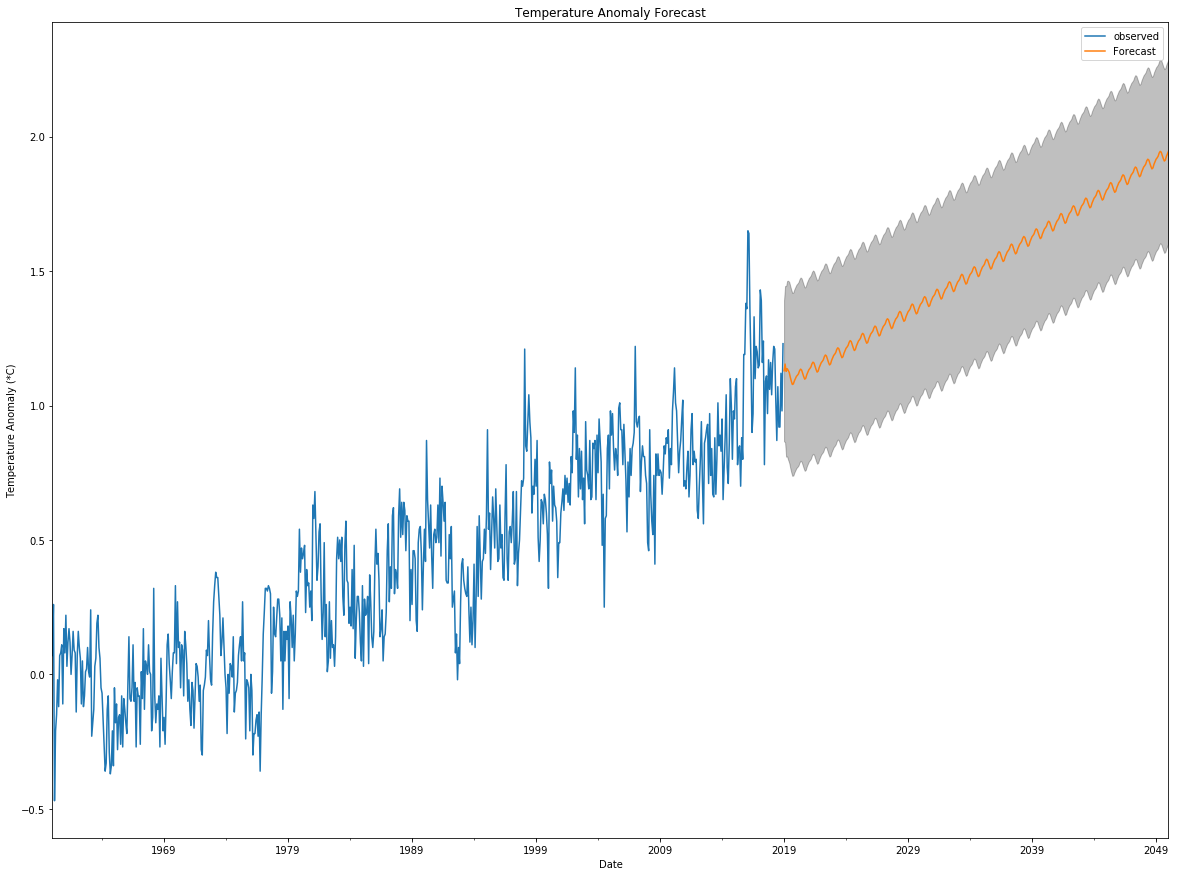

In [63]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Temperature Anomaly Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()

## SARIMA-prediction

In [64]:
mod = sm.tsa.statespace.SARIMAX(anomalyrange.anomaly,order=(2,1,2),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 378.278
Date:                Sun, 17 Feb 2019   AIC                           -744.555
Time:                        00:46:02   BIC                           -717.180
Sample:                    01-01-1960   HQIC                          -733.979
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      5.380      0.000       0.000       0.001
ar.L1          0.1886      0.119      1.591      0.112      -0.044       0.421
ar.L2          0.4115      0.067      6.112      0.000       0.280       0.544
ma.L1         -0.7337      0.138     -5.309      0.000      -1.004      -0.463
ma.L2         -0.2667      0.132     -2.016      0.044      -0.526      -0.007
sigma2         0.0196      0.002      9.797      0.000       0.016       0.024
===================================================================================
Ljung-Box (Q):                       50.77   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.12   Prob(JB):                         0.30
Heteroskedasticity (H):               1.15   Skew:                             0.13
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
prediction = res.get_forecast(steps=373)

In [66]:
prediction.predicted_mean.tail()

2049-09-01    1.684772
2049-10-01    1.686525
2049-11-01    1.688279
2049-12-01    1.690032
2050-01-01    1.691785
Freq: MS, dtype: float64

In [67]:
pred_ci = prediction.conf_int()

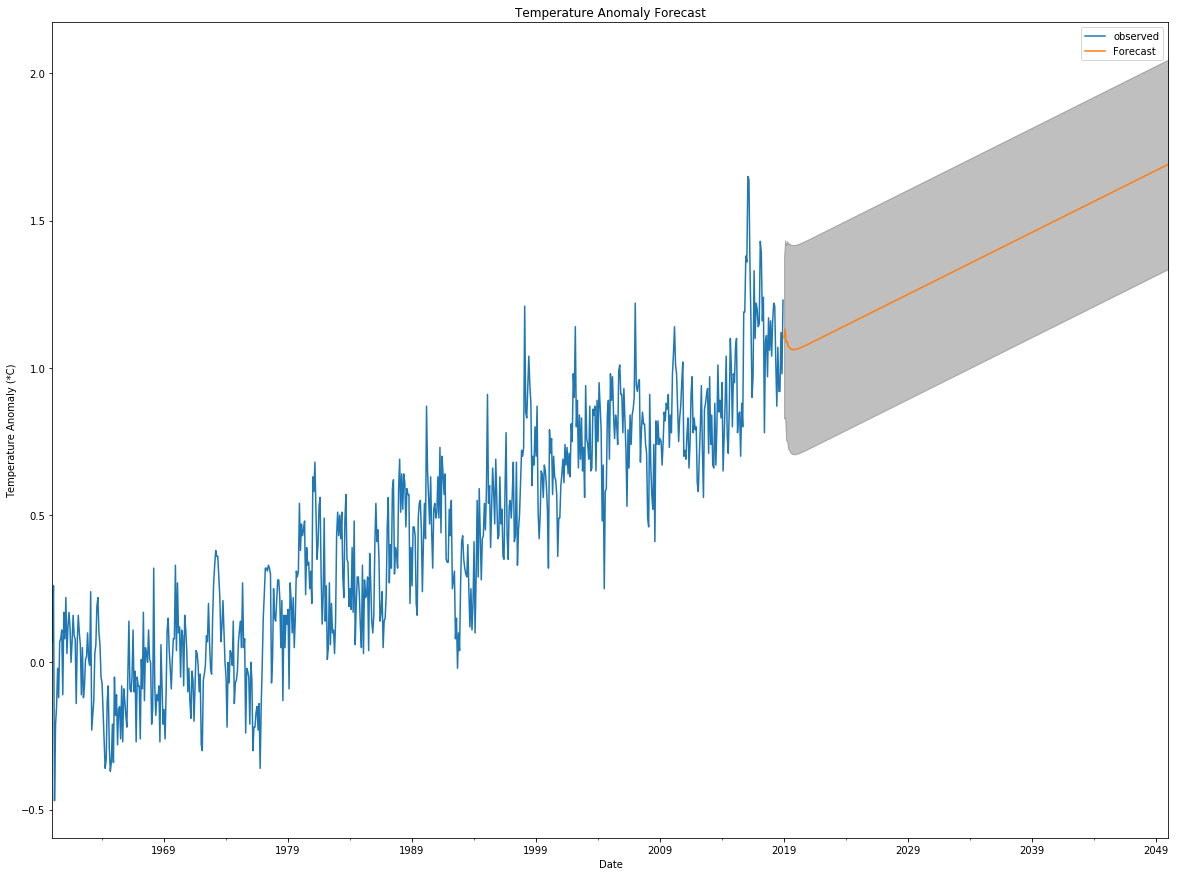

In [68]:
ax = anomalyrange.anomaly.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Temperature Anomaly Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature Anomaly (*C)')

plt.legend()
plt.show()